This code was heavily based on Enge et al. 2021 codes available at https://osf.io/34ry2/ (we are highly grateful for their commitment to open research)

In [1]:
import random
from glob import glob
from math import sqrt
from os import makedirs, path
from re import sub
from shutil import copy
from sys import argv

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from nibabel import save
from nilearn import image, plotting, reporting
from nimare import correct, io, meta, utils
from scipy.stats import norm

from datetime import datetime

import os


In [ ]:
# ========== 与 1_ALE.ipynb 对齐，MacBook 友好 ==========
# 输入：与 1_ALE 使用同一 Sleuth 文件（约 10+ 研究）
TEXT_FILE = "../1_Data/AnalysisData/InputData_ALE/hyper_and_hypo.txt"
OUTPUT_ROOT = "../3_Output/7_FSN"

# ALE 参数（与 1_ALE 一致；n_iters 降低以提速）
VOXEL_THRESH = 0.001
CLUSTER_THRESH = 0.05
N_ITERS = 5000
RANDOM_ALE_SEED = 2025

# FSN 设置：filedrawer 数少一点以缩短总时间
NR_FILEDRAWERS = 2
K_MAX_FACTOR = 5

PREFIX = path.basename(TEXT_FILE).replace(".txt", "")

Our FSN simulations will heavily rely on the generation of so called "null experiments," i.e., fictional experiments with their peaks randomly distributed across the brain. We'll start by writing a helper function for creating these. It takes as its input a "real" ALE data set (in the form of a Sleuth text file, as in the ALE script). It then creates a desired number (`k_null`) of null experiments that are similar to the real experiments in terms of sample sizes and number of peak coordinates. However, the location of these peaks is drawn randomly from all voxels within our gray matter template. For these experiments, we know that the null hypothesis (i.e., no spatial convergence) is true, thus providing a testing ground for the file drawer effect.

In [2]:
# Define function to generate a new data set with k null studies added
def generate_null(
    text_file="peaks.txt",
    space="ale_2mm",
    k_null=100,
    random_seed=None,
    output_dir="./",
):

    # Load NiMARE's gray matter template
    temp = utils.get_template(space=space, mask="brain")

    # Extract possible MNI coordinates for all gray matter voxels
    x, y, z = np.where(temp.get_fdata() == 1.0)
    within_mni = image.coord_transform(x=x, y=y, z=z, affine=temp.affine)
    within_mni = np.array(within_mni).transpose()

    # Read the original Sleuth file into a NiMARE data set
    dset = io.convert_sleuth_to_dataset(text_file, target=space)

    # Set a random seed to make the results reproducible
    if random_seed:
        random.seed(random_seed)

    # Resample numbers of subjects per experiment based on the original data
    nr_subjects_dset = [n[0] for n in dset.metadata["sample_sizes"]]
    nr_subjects_null = random.choices(nr_subjects_dset, k=k_null)

    # Resample numbers of peaks per experiment based on the original data
    nr_peaks_dset = dset.coordinates["study_id"].value_counts().tolist()
    nr_peaks_null = random.choices(nr_peaks_dset, k=k_null)

    # Create random peak coordinates
    idx_list = [
        random.sample(range(len(within_mni)), k=k_peaks) for k_peaks in nr_peaks_null
    ]
    peaks_null = [within_mni[idx] for idx in idx_list]

    # Copy original experiments to the destination Sleuth file
    makedirs(output_dir, exist_ok=True)
    text_file_basename = path.basename(text_file)
    null_file_basename = sub(
        pattern=".txt", repl="_plus_k" + str(k_null) + ".txt", string=text_file_basename
    )
    null_file = output_dir + "/" + null_file_basename
    copy(text_file, null_file)

    # Append all the null studies to the Sleuth file
    f = open(null_file, mode="a")
    for i in range(k_null):
        f.write(
            "\n// nullstudy"
            + str(i + 1)
            + "\n// Subjects="
            + str(nr_subjects_null[i])
            + "\n"
        )
        np.savetxt(f, peaks_null[i], fmt="%.3f", delimiter="\t")
    f.close()

    # Read the new Sleuth file and return it as a NiMARE data set
    dset_null = io.convert_sleuth_to_dataset(null_file, target=space)
    return dset_null

With this helper function, we can go on to implement the actual FSN simulation. This function will be rather long-winded and complex, but the overall logic is simple: Take the Sleuth file from the original ALE analysis, generate a large number of null experimetns, and add them iteratively to the analysis. At each step, re-estimate the ALE and record which voxel have remained statistically significant and which have not. Based on this, each (initially singificant) voxel will be assigned an FSN value which is equal to the highest number of null experiments that we were able to add before the voxel failed to reach significant for the first time. Because these simulations are going to take a really (!) long time, we implement two stopping rules: We either stop if there are no more significant voxels left *or* if we've added a sufficiently large number of null studies for our purpose (e.g., five times times the number of original studies in the meta-analysis).

In [5]:
# Define function to compute the FSN for all voxels from a Sleuth file
def compute_fsn(
    text_file="peaks.txt",
    space="ale_2mm",
    voxel_thresh=0.001,
    cluster_thresh=0.05,
    n_iters=10000,
    k_max_factor=5,
    random_ale_seed=None,
    random_null_seed=None,
    output_dir="./",
):

    # Let's show the user what we are doing
    now = datetime.now()
    now_str = now.strftime("%d/%m/%Y %H:%M:%S")
    #print("\nCOMPUTING FSN FOR " + text_file + 
    #      " (seed: " + 
    #      str(random_null_seed) + 
    #      " - starting at:" now)")
    print(
        '\nCOMPUTING FSN FOR "'
        + text_file
        + '" (seed:  '
        + str(random_null_seed)
        + " - starting at:"
        + now_str
    )    

    # Set random seed for original ALE if requested
    if random_ale_seed:
        np.random.seed(random_ale_seed)

    # Recreate the original ALE analysis（为避免 Jupyter 多进程报错，这里使用单核）
    ale = meta.cbma.ALE(n_cores=1)
    corr = correct.FWECorrector(
        method="montecarlo", voxel_thresh=voxel_thresh, n_iters=n_iters, n_cores=1
    )
    dset_orig = io.convert_sleuth_to_dataset(text_file=text_file, target=space)
    res_orig = ale.fit(dset_orig)
    cres_orig = corr.transform(res_orig)

    # Extract the original study IDs
    ids_orig = dset_orig.ids.tolist()

    # Create a new data set with a large number null studies added
    k_max = len(ids_orig) * k_max_factor
    dset_null = generate_null(
        text_file=text_file,
        space=space,
        k_null=k_max,
        random_seed=random_null_seed,
        output_dir=output_dir,
    )

    # Create thresholded cluster mask
    img_fsn = cres_orig.get_map("z_desc-size_level-cluster_corr-FWE_method-montecarlo")
    cluster_thresh_z = norm.ppf(1 - cluster_thresh / 2)
    img_fsn = image.threshold_img(img_fsn, threshold=cluster_thresh_z)
    img_fsn = image.math_img("np.where(img > 0, 1, 0)", img=img_fsn)

    # Create cluster-thresholded z map
    img_z = cres_orig.get_map("z")
    img_z = image.math_img("img1 * img2", img1=img_fsn, img2=img_z)

    # Iteratively add null studies up to our pre-defined maximum
    for k in range(1, k_max):
        ale = meta.cbma.ALE(n_cores=1)
        corr = correct.FWECorrector(
            method="montecarlo", voxel_thresh=voxel_thresh, n_iters=n_iters, n_cores=1
        )

        # Print message
        print("Computing ALE for k = " + str(k) + " null studies added...")

        # Create a new data set with k null studies added
        ids_null = ["nullstudy" + str(x) + "-" for x in range(1, k + 1)]
        ids = ids_orig + ids_null
        dset_k = dset_null.slice(ids)

        # Compute the ALE
        res_k = res = ale.fit(dset_k)
        cres_k = corr.transform(result=res_k)

        # Create a thresholded cluster mask
        img_k = cres_k.get_map("z_desc-size_level-cluster_corr-FWE_method-montecarlo")
        img_k = image.threshold_img(img_k, threshold=cluster_thresh_z)
        img_k = image.math_img("np.where(img > 0, 1, 0)", img=img_k)

        # Use this to update the per-voxel FSN - this is a bit hack-ish: On a voxel-by-
        # voxel basis, we increase the value by 1 if and only if the voxel has remained
        # significant. As soon as it has failed to reach significance once, we never
        # increase FSN any further. This is handeled by comparing the current FSN to
        # the current value of k.
        count = str(k + 1)
        formula = "np.where(img_fsn + img_k == " + count + ", img_fsn + 1, img_fsn)"
        img_fsn = image.math_img(formula, img_fsn=img_fsn, img_k=img_k)

        # Quit as soon as there are no significant clusters left in the current map
        if not np.any(img_k.get_fdata()):
            print("No more significant voxels - terminating\n")
            break

    # Save the FSN map that we've created in the loop
    filename_img = path.basename(text_file).replace(".txt", "_fsn.nii.gz")
    save(img_fsn, filename=output_dir + "/" + filename_img)

    # Extract the FSN values at the original cluster peaks
    tab_fsn = reporting.get_clusters_table(img_z, stat_threshold=0, min_distance=1000)
    filename_tab = path.basename(text_file).replace(".txt", "_fsn.tsv")
    out_path_tab = path.join(output_dir, filename_tab)

    if tab_fsn.empty:
        tab_fsn.to_csv(out_path_tab, sep="\t", index=False)
    else:
        inv_affine = np.linalg.inv(img_z.affine)
        x, y, z = [np.array(tab_fsn[col]) for col in ["X", "Y", "Z"]]
        x, y, z = image.coord_transform(x=x, y=y, z=z, affine=inv_affine)
        x, y, z = [arr.astype("int") for arr in [x, y, z]]
        tab_fsn["FSN"] = img_fsn.get_fdata()[x, y, z]
        tab_fsn.to_csv(out_path_tab, sep="\t", index=False)

    return img_fsn, tab_fsn

In [ ]:
# 使用上面配置 cell 的变量：TEXT_FILE, OUTPUT_ROOT, PREFIX, N_ITERS, RANDOM_ALE_SEED, NR_FILEDRAWERS, K_MAX_FACTOR, VOXEL_THRESH, CLUSTER_THRESH
prefixes = [PREFIX]
text_files = [TEXT_FILE]
output_dirs = [path.join(OUTPUT_ROOT, PREFIX) + "/"]
makedirs(output_dirs[0], exist_ok=True)

random_null_seeds = random.sample(range(1000), k=NR_FILEDRAWERS)
filedrawers = ["filedrawer" + str(seed) for seed in random_null_seeds]

for text_file, output_dir in zip(text_files, output_dirs):
    for random_null_seed, filedrawer in zip(random_null_seeds, filedrawers):
        drawer_dir = path.join(output_dir, filedrawer)
        compute_fsn(
            text_file=text_file,
            space="ale_2mm",
            voxel_thresh=VOXEL_THRESH,
            cluster_thresh=CLUSTER_THRESH,
            n_iters=N_ITERS,
            k_max_factor=K_MAX_FACTOR,
            random_ale_seed=RANDOM_ALE_SEED,
            random_null_seed=random_null_seed,
            output_dir=drawer_dir,
        )

print("Finished at", datetime.now().strftime("%d/%m/%Y %H:%M:%S"))


COMPUTING FSN FOR "/Volumes/ss/Self_Psych_Meta/1_Data/AnalysisData/InputData_ALE/hyperactivation.txt" (seed:  128 - starting at:20/02/2026 19:22:02


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.
100%|██████████| 10000/10000 [35:52<00:00,  4.65it/s]
INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.
/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_1709/1271075731.py:59: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  img_fsn = image.threshold_img(img_fsn, threshold=cluster_thresh_z)
/Users/ss/miniconda3/lib/python3.12/site-packages/nilearn/image/image.py:1160: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility th

Computing ALE for k = 1 null studies added...


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.
100%|██████████| 10000/10000 [37:01<00:00,  4.50it/s]
INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.
/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_1709/1271075731.py:87: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  img_k = image.threshold_img(img_k, threshold=cluster_thresh_z)
/Users/ss/miniconda3/lib/python3.12/site-packages/nilearn/image/image.py:1160: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the da

Computing ALE for k = 2 null studies added...


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.
100%|██████████| 10000/10000 [38:51<00:00,  4.29it/s] 
INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.
/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_1709/1271075731.py:87: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  img_k = image.threshold_img(img_k, threshold=cluster_thresh_z)
/Users/ss/miniconda3/lib/python3.12/site-packages/nilearn/image/image.py:1160: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the d

Computing ALE for k = 3 null studies added...


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.
100%|██████████| 10000/10000 [40:41<00:00,  4.10it/s]
INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.
/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_1709/1271075731.py:87: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  img_k = image.threshold_img(img_k, threshold=cluster_thresh_z)
/Users/ss/miniconda3/lib/python3.12/site-packages/nilearn/image/image.py:1160: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the da

Computing ALE for k = 4 null studies added...


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.
100%|██████████| 10000/10000 [42:07<00:00,  3.96it/s]
INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.
/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_1709/1271075731.py:87: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  img_k = image.threshold_img(img_k, threshold=cluster_thresh_z)
/Users/ss/miniconda3/lib/python3.12/site-packages/nilearn/image/image.py:1160: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the da

Computing ALE for k = 5 null studies added...


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.
100%|██████████| 10000/10000 [42:26<00:00,  3.93it/s]
INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.
/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_1709/1271075731.py:87: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  img_k = image.threshold_img(img_k, threshold=cluster_thresh_z)
/Users/ss/miniconda3/lib/python3.12/site-packages/nilearn/image/image.py:1160: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the da

Computing ALE for k = 6 null studies added...


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.
100%|██████████| 10000/10000 [42:54<00:00,  3.88it/s]
INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.
/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_1709/1271075731.py:87: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  img_k = image.threshold_img(img_k, threshold=cluster_thresh_z)
/Users/ss/miniconda3/lib/python3.12/site-packages/nilearn/image/image.py:1160: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the da

Computing ALE for k = 7 null studies added...


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.
100%|██████████| 10000/10000 [43:51<00:00,  3.80it/s]
INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.
/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_1709/1271075731.py:87: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  img_k = image.threshold_img(img_k, threshold=cluster_thresh_z)
/Users/ss/miniconda3/lib/python3.12/site-packages/nilearn/image/image.py:1160: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the da

Computing ALE for k = 8 null studies added...


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.
 69%|██████▉   | 6939/10000 [31:12<1:11:30,  1.40s/it]

Once the simulation are done, we need to aggregate the results that we've obtained for each analysis across multiple file drawers. Remember that for each file drawer, we've already stored an FSN map as well as a table that contains the FSN value for each of the original cluster peaks. Here we just average these maps and perform some summary statistics on the tables, such as computing the mean FSN and its 95% confidence interval across the multiple file drawers (in our case, ten).

In [ ]:
# 聚合所有 filedrawer，得到 mean FSN 的 .nii.gz 和 .csv（与 1_ALE 同参数、同 prefix）
base_dir = path.join(OUTPUT_ROOT, PREFIX)
prefix = PREFIX

fnames_maps = glob(path.join(base_dir, "filedrawer*", prefix + "_fsn.nii.gz"))
if not fnames_maps:
    raise FileNotFoundError("未找到任何 FSN map，请先运行上面的 compute_fsn 循环。路径: " + base_dir)

imgs_fsn = [image.load_img(f) for f in fnames_maps]
img_mean = image.mean_img(imgs_fsn)
fname_img_mean = path.join(base_dir, prefix + "_mean_fsn.nii.gz")
save(img_mean, fname_img_mean)
print("Saved:", fname_img_mean)

fnames_tabs = glob(path.join(base_dir, "filedrawer*", prefix + "_fsn.tsv"))
tabs_fsn = [pd.read_csv(f, sep="\t") for f in fnames_tabs]
tab_fsn = pd.concat(tabs_fsn, ignore_index=True)
fname_agg = path.join(base_dir, prefix + "_mean_fsn.csv")

if tab_fsn.empty or "Cluster ID" not in tab_fsn.columns or "FSN" not in tab_fsn.columns:
    pd.DataFrame().to_csv(fname_agg, index=False)
    print("No cluster FSN data; saved empty CSV:", fname_agg)
else:
    agg = tab_fsn.groupby("Cluster ID")["FSN"].agg(["mean", "count", "std"])
    z_crit = abs(norm.ppf(0.05 / 2))
    agg["se"] = agg["std"] / np.sqrt(agg["count"])
    agg["ci_lower"] = agg["mean"] - z_crit * agg["se"]
    agg["ci_upper"] = agg["mean"] + z_crit * agg["se"]
    agg.to_csv(fname_agg, float_format="%.3f")
    print("Saved:", fname_agg)


/var/folders/yk/78rqxlxn4pz_rsb5_31xvh340000gn/T/ipykernel_35944/3288931184.py:16: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  img_mean = image.mean_img(imgs_fsn)


# FSN 绘图

参考 Enge 等人的思路：将 FSN 结果分为「高于阈值」（稳健）与「低于阈值」（不稳健）两部分，分别用绿/红 overlay 展示。  
由于 02_FSN 输出的是体素级 mean FSN 图，这里按体素 FSN 值设定 cutoff（如 30% × 研究数），分割为 below/above 并绘图。

/Users/ss/miniconda3/lib/python3.12/site-packages/nilearn/plotting/displays/_slicers.py:313: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)


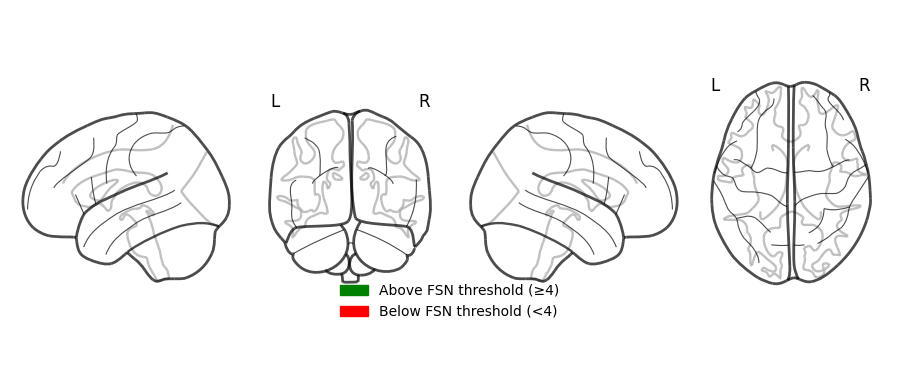

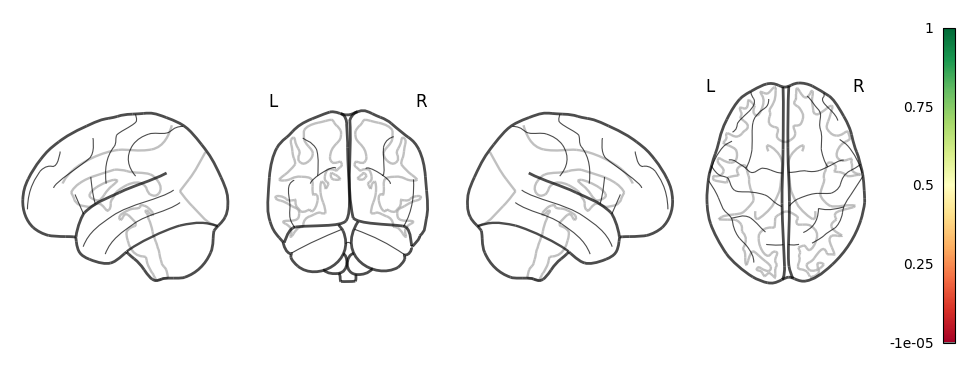

In [8]:
# FSN 绘图（需先运行完上面的聚合 cell，生成 mean_fsn.nii.gz）
base_dir = path.join(OUTPUT_ROOT, PREFIX)

# 加载 mean FSN 图（体素级 FSN 值）
img_fsn = image.load_img(path.join(base_dir, PREFIX + "_mean_fsn.nii.gz"))
data = img_fsn.get_fdata()

# 阈值：FSN 低于此值视为「不稳健」。常用 30% × 原始研究数
n_studies = 15  # 根据你的 hyper_and_hypo 研究数调整
fsn_threshold = max(1, 0.3 * n_studies)  # 至少为 1

# 分割为 below（红）和 above（绿）mask
img_below = image.new_img_like(img_fsn, ((data > 0) & (data < fsn_threshold)).astype(float))
img_above = image.new_img_like(img_fsn, (data >= fsn_threshold).astype(float))

# Glass brain 叠加
fsn_plot = plotting.plot_glass_brain(None, display_mode="lyrz")
fsn_plot.add_overlay(img_below, cmap="OrRd", vmin=0, vmax=1, colorbar=False)
fsn_plot.add_overlay(img_above, cmap="RdYlGn", vmin=0, vmax=1, colorbar=False)

green_patch = mpatches.Patch(color="green", label="Above FSN threshold (≥{:.0f})".format(fsn_threshold))
red_patch = mpatches.Patch(color="red", label="Below FSN threshold (<{:.0f})".format(fsn_threshold))
plt.legend(handles=[green_patch, red_patch], loc="lower center", frameon=False, bbox_to_anchor=(-1.2, -0.08), borderaxespad=0.)
plt.show()

# 可选：直接显示 FSN 数值的 glass brain（连续色阶）
plotting.plot_glass_brain(img_fsn, display_mode="lyrz", colorbar=True, cmap="RdYlGn", vmin=0, vmax=max(1, data.max()))